# Stargate SG1 Script Corpus Creation Process
### Process raw scripts from season 1 to the end of season 5 from imsdb into a table and review

Thomas Bowe

* [Introduction](#section-one)
* [Initial Load of Sample Episode (E01S01)](#section-two)
* [Categorisation of Each Line of Script](#section-three)
* [Trimming the Content Field](#section-four)
* [Episode Information Extraction](#section-five)
* [Add Episode Information as Seperate Fields](#section-six)
* [Add Character Field](#section-seven)
* [Fill Down Character Designations to Their Associated Dialogue](#section-eight)
* [Create Line Index](#section-nine)
* [Consolidate Data Based on Line Index](#section-ten)
* [Create For Loop to Process Multiple Episode Files Into a Corpus](#section-eleven)
* [Review Data Where text_type is "Other" Indicating an Error](#section-twelve)
* [Review All Episodes For Writing Style Changes](#section-thirteen)
    - [Total Direction Frequency Review](#subsection-one)
    - [Total Character Dialogue Lines Frequency Review](#subsection-two)
    - [Main Character Line Frequency Review](#subsection-three)
    - [Frequency of Main Character Mentions in Dialogue](#subsection-four)
* [Preview of Stargate SG1 Corpus](#section-fourteen)

<a id="section-one"></a>
# Introduction
The purpose of this workbook is to document the process for creating a Stargate SG1 Corpus up until at least when Daniel Ascended for use in exploratory data analytics, text mining, sentiment analysis, etc. Scripts were sourced from https://www.imsdb.com/TV/Stargate%20SG1.html and saved as .txt with only minor alterations to the content made manually. The scripts are available only up until season 9, episode 10 which is unfortunate but arguably the show changed dramatically from season 6 so I will focus on these seasons as a priority.

I noted that the transcription of the episodes often varied in style, likely due to different transcribers, and while I could modify the code to accomodate it in most cases, some styles were riddled with transcriber commentary inside the dialogue or direction lines. I was able to remove this reliably from dialogue but directions retain some of it but I deem this to be acceptable. Some of the commentary is quite funny as it generally revolved around the transcriber noting how good looking the male characters look in various scenes.

<a id="section-two"></a>
# Initial Load of Sample Episode (E01S01)

I have scraped all the scripts from https://www.imsdb.com/TV/Stargate%20SG1.html as .txt files. I will import a sample file being the first episode of the first season "Children of the Gods" in order to determine the best process of converting each episode into a corpus. A sample of the raw scripts is below:

In [1]:
library(tidyverse)
library(gdata)
library(tm)
library(tidyr)
library(plotly)
library(stringi)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.


Attaching package: ‘gdata’


The following objects are masked from ‘package:dplyr’:

    combine, first, last


The following object is masked from ‘package:purrr’:

    keep


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘

In [2]:
# Create the core theme function
theme_tb <- function() {
  theme(
    panel.background = element_blank(),
    axis.ticks = element_blank(),    
    plot.title = element_text(size = 26, hjust = 0),                                                                        
    plot.subtitle = element_text(hjust = 0, size = 14),          
    plot.caption = element_text(size = 14, hjust = 1),                           
    axis.title = element_text(size = 18),             
    axis.text.y = element_text(size = 18),          
    axis.text.x = element_text(size = 18, margin = margin(5, b = 10)),
    strip.text = element_text(size = 16, hjust = 0, face = "bold"),
    strip.background = element_blank(),
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 14),
    legend.background = element_blank(),
    legend.key = element_blank(),
    plot.margin = unit(c(1,2,.5,.5), "cm")
  )
}

In [3]:
ep = readLines("/kaggle/input/stargate-sg1-scripts/S01E01.txt") %>% tibble(content = .)

In [4]:
head(ep,30)

content
<chr>
STARGATE SG1
""
Episode 101
""
"""CHILDREN OF THE GODS"""
""
By
""
Jonathan Glassner & Brad Wright


<a id="section-three"></a>
# Categorisation of Each Line of Script

Each script has some episode information at the top followed by either directions, character names, dialogue, or blank space which is either genuine blank space or a number of spaces. They key to making a distinction between these is the indentation/spacing. I start by searching for 3 main types of indentation and creating a new column which loosly identifies each row of the script.

In [5]:
# Each line of script is able to be categorised based on the indentation
ep <-
  mutate(
    ep,
    text_type = case_when(
      str_detect(content, "                                     ") == TRUE ~ "Character",
      str_detect(content, "                         ") == TRUE ~ "Script",
      str_detect(content, "               ") == TRUE ~ "Directions",
      TRUE ~ "Other"
    )
  )
# Preview categorised data
head(ep, 30)

content,text_type
<chr>,<chr>
STARGATE SG1,Character
,Other
Episode 101,Character
,Other
"""CHILDREN OF THE GODS""",Script
,Other
By,Character
,Other
Jonathan Glassner & Brad Wright,Script


<a id="section-four"></a>
# Trimming the Content Field

Note that the first 9 rows are unique in each epsiode script and I will extract the information contained in these rows and then delete them in subsequent steps, I.e. the fact they've been assigned nonsensical categories will not matter. For now though, I am done with the information the indentation provided so I will trim the content field. Because the spaces are now removed I can easily identify a blank row and I will remove these in the same step. I require the gdata package for the trim function.

In [6]:
ep <-
  mutate(ep, content = trim(content)) %>%
  subset(content != "")
head(ep, 12)

content,text_type
<chr>,<chr>
STARGATE SG1,Character
Episode 101,Character
"""CHILDREN OF THE GODS""",Script
By,Character
Jonathan Glassner & Brad Wright,Script
The opening scene starts in the gateroom. The gate is covered,Directions
and in a corner of the room a group of four military personnel,Directions
are playing a game of cards.,Directions
AIRMAN,Character


<a id="section-five"></a>
# Episode Information Extraction

The top 5 rows now contain information I wish to extract prior to deletion. In this step I assign these to variables.

In [7]:
# Extract the episode name and remove alphanumerics excluding hyphen
episode_name <-
  ep[3, 1] %>%
  pull %>%
  trim %>%
  str_replace_all("[^[:alnum:]'-]", " ")
# Extract the episode writer's name
episode_writer <-
  ep[5, 1] %>%
  pull %>%
  trim
# Extract the episode number
episode_number <-
  ep[2, 1] %>%
  pull %>%
  trim %>%
  substr(9, 9)
# Extract the season number
season_number <-
  ep[2, 1] %>%
  pull %>%
  trim %>%
  substr(10, 11)

<a id="section-six"></a>
# Add Episode Information as Seperate Fields 

Now I have extracted this data from the top rows, I add them as columns and finally remove the top 5 rows leaving only dialogue, directions, or character designations.

In [8]:
# Add the extracted episode information as new columns
ep <-
  mutate(
    ep,
    season_number = season_number,
    episode_number = episode_number,
    episode_name = episode_name,
    episode_writer = episode_writer
  ) %>% tail(-5)
# Preview the data with the episode information added
head(ep)

content,text_type,season_number,episode_number,episode_name,episode_writer
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
The opening scene starts in the gateroom. The gate is covered,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright
and in a corner of the room a group of four military personnel,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright
are playing a game of cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright
"Oh, man, this hand's as lousy as this",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright
"detail. All right, everybody in or out.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright


<a id="section-seven"></a>
# Add Character Field

The data is starting to become cleaner. Importantly, where I have identified the script I will use this information to create a new field called "character". We do this by transfering over the character name from the content field if text_type == Character, and if text_type == Directions we simply transfer this fact over as well. Instead of carrying script I reassign it as NA.

In [9]:
# Extract the character name from the content column and create a new column called character
ep <-
  mutate(
    ep,
    character = case_when(
      str_detect(text_type, "Character") == TRUE ~ content,
      str_detect(text_type, "Direction") == TRUE ~ "Directions",
      TRUE ~ NA_character_
    )
  )
# Preview the data with the character information
head(ep)

content,text_type,season_number,episode_number,episode_name,episode_writer,character
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
The opening scene starts in the gateroom. The gate is covered,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
and in a corner of the room a group of four military personnel,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
are playing a game of cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN
"Oh, man, this hand's as lousy as this",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,NA
"detail. All right, everybody in or out.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,NA


<a id="section-eight"></a>
# Fill Down Character Designations to Their Associated Dialogue

Now I am able to rely on these NA fields to represent the dialogue belonging to the above listed character. I then fill this down for all rows in the table.

In [10]:
# Fill down the NA fields with the character name from the next filled cell above
ep <- 
  fill(ep, character)
# Preview the data with completed character field
head(ep)

content,text_type,season_number,episode_number,episode_name,episode_writer,character
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
The opening scene starts in the gateroom. The gate is covered,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
and in a corner of the room a group of four military personnel,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
are playing a game of cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN
"Oh, man, this hand's as lousy as this",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN
"detail. All right, everybody in or out.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN


<a id="section-nine"></a>
# Create Line Index

The next step is to consolidate each line of dialogue and direction into a single row of data. To do this I first assign each character designation/line/dialogue an index with the intention of rolling up the content field based on this index ie everything beloning to a unique index number will be concatenated together.

In [11]:
# Create a line index column
ep <-
  mutate(ep, line_index = cumsum(ifelse(
    text_type != lag(text_type) | is.na(lag(text_type)), 1, 0
  )))
# Preview data with line index column added
head(ep)

content,text_type,season_number,episode_number,episode_name,episode_writer,character,line_index
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
The opening scene starts in the gateroom. The gate is covered,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions,1
and in a corner of the room a group of four military personnel,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions,1
are playing a game of cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions,1
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,2
"Oh, man, this hand's as lousy as this",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,3
"detail. All right, everybody in or out.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,3


<a id="section-ten"></a>
# Consolidate Data Based on Line Index

I am able to group by line index now and collapse each row in the content field. I then simply remove duplicates which effectively leaves me with a character's line to a row.

In [12]:
# Group the data by the line index field, effectively creating a new dataset with a unique line per row
ep <-
  group_by(ep, line_index) %>%
  mutate(content = paste0(content, collapse = " ")) %>%
  unique()
# Preview the line grouped data
head(ep, 10)

content,text_type,season_number,episode_number,episode_name,episode_writer,character,line_index
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
The opening scene starts in the gateroom. The gate is covered and in a corner of the room a group of four military personnel are playing a game of cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions,1
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,2
"Oh, man, this hand's as lousy as this detail. All right, everybody in or out.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,3
One of the personnel deals out some cards.,Directions,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,Directions,4
AIRMAN,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,5
"Seven to the deuce, nothing there, boss on the eight, nothing happening, queen to the king, possible straight going there, eight on the eight, and the jack gets a box. Eight's open.",Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,AIRMAN,6
FEMALE,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,FEMALE,7
Aren't you guys afraid of an officer coming down here or something?,Script,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,FEMALE,8
OFFICER,Character,01,1,CHILDREN OF THE GODS,Jonathan Glassner & Brad Wright,OFFICER,9


<a id="section-eleven"></a>
# Create For Loop to Process Multiple Episode Files Into a Corpus

I indicate the directory where the scripts are stored then define the filenames and create a list to populate. The loop then closely follows the above detailed workings but iterates over all raw episode files in the dataset. The final product is removed of superfluous columns and rows and the columns are ordered in an intuitve fashion including the inclusion of an index column.

In [13]:
# Assign the directory location
dir <-
  "../input/stargate-sg1-scripts"
# Define the file names
filenames <-
  list.files(path = dir, pattern = "*.txt")
# Create a list to fill during the loop
datalist <-
  list()

In [14]:
for(i in filenames) {
  # Name the filepath after the episode file name
  filepath <-
    file.path(paste0("../input/stargate-sg1-scripts/", i))
  # Extract the data from each script flat file and convert to a dataframe for episode information extraction
  extract <-
    readLines(filepath) %>%
    data_frame(content = .)
  # Extract the episode name from the file
  episode_name <-
    extract[5, 1] %>%
    pull %>%
    trim %>%
    str_replace_all("[^[:alnum:]'-]", " ")
  # Extract the episode writer's name from the file
  episode_writer <-
    extract[9, 1] %>%
    pull %>%
    trim
  # Extract the data from each script flat file and convert to a dataframe for processing into corpus format
  datalist[[i]] <- assign(
    i,
    readLines(filepath) %>%
      data_frame(content = .) %>%
      # Add the season number and episode number columns from the flat filepath name
      mutate(
        season_number = filepath %>%
          substr(32, 33) %>%
          as.numeric(),
        episode_number = filepath %>%
          substr(35, 36) %>%
          as.numeric(),
        # Add the episode name and episode writer's name from the data we extracted previously
        episode_name = episode_name,
        episode_writer = episode_writer,
        # Categorise each line of the script as Character, Script, or Directions
        text_type = case_when(
          str_detect(content, "                                     ") == TRUE ~ "Character",
          str_detect(content, "                         ") == TRUE ~ "Script",
          str_detect(content, "               ") == TRUE ~ "Directions",
          TRUE ~ "Other"
        )
      ) %>%
      # Clean the content column up by replacing alphanumerics, punctuation, rogue spacing, blank cells, etc
      mutate(content = str_replace_all(content, "' ", "'")) %>%
      mutate(content = str_replace_all(content, "'", "")) %>%
      mutate(content = str_replace_all(content, "[^[:alnum:]'()]", " ")) %>%
      mutate(content = gsub(' +', ' ', content)) %>%
      mutate(content = str_trim(content, side = "both")) %>%
      subset(content != "") %>%
      tail(-5) %>%
      # Create the character column
      mutate(
        character = case_when(
          str_detect(text_type, "Character") == TRUE ~ content,
          str_detect(text_type, "Direction") == TRUE ~ "Directions",
          TRUE ~ NA_character_
        )
      ) %>%
      fill(character) %>%
      # Create line index
      mutate(line_index = cumsum(ifelse(
        text_type != lag(text_type) | is.na(lag(text_type)), 1, 0
      ))) %>%
      # Conslolidate all rows by line index
      group_by(line_index) %>%
      mutate(content = paste0(content, collapse = " ")) %>%
      unique() %>%
      ungroup(line_index)
  ) 
}

Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Next I bind rows on the data list to create the sg1corpus, create an episode index, remove the character designations, select fields going forward, lower case all fields, and remove ampersand symbol in episode writer field.

In [15]:
sg1corpus <-
  bind_rows(datalist, .id = "column_label") %>%
  mutate(episode_index = cumsum(ifelse(
    episode_number != lag(episode_number) |
      is.na(lag(episode_number)), 1, 0
  ))) %>%
  subset(text_type != "Character") %>%
  mutate(
    character = tolower(character),
    episode_name = tolower(episode_name),
    episode_writer = str_replace_all(tolower(episode_writer), "&", "and"),
    # Remove anything between brackets in dialogue and directions assumed to be transcriber commentary
    content = str_replace_all(tolower(content), "\\(.*?\\)", "")
  ) %>%
  # Remove any instance of backslash symbol
  mutate(character = str_replace_all(character, "\\\\", "")) %>%
  # Make all character name indicators consistent in both character and content fields
  mutate(character = str_replace_all(character, "oneill", "jack")) %>%
  mutate(character = str_replace_all(character, "carter", "sam")) %>%
  mutate(character = str_replace_all(character, "danny", "daniel")) %>%
  mutate(character = str_replace_all(character, "jackson", "daniel")) %>%
  mutate(character = str_replace_all(character, "davis", "harriman")) %>%
  mutate(character = str_replace_all(character, "gh", "hammond")) %>%
  mutate(character = str_replace_all(character, "technician", "tech")) %>%
  mutate(character = str_replace_all(character, "fraiser", "janet")) %>%
  mutate(character = str_replace_all(character, "ag", "malakai")) %>%
  mutate(character = str_replace_all(character, "teal c", "tealc")) %>%
  # Sometimes there was very brief indicators of who the character was talking to immediately after the character name this was deemed low value and removed
  mutate(character = str_replace_all(character, "\\(.*?\\)", "")) %>%
  mutate(content = str_replace_all(content, "teal c", "tealc")) %>%
  mutate(content = str_replace_all(content, "o neill", "oneill")) %>%
  mutate(content = str_replace_all(content, " gh ", " hammond ")) %>%
  mutate(content = str_replace_all(content, "apophis", "apophis ")) %>%
  # Remove leading spaces
  mutate(content = str_trim(content, side = "both")) %>%
  # Remove double spaces
  mutate(content = str_squish(content)) %>%
  # Create index
  rowid_to_column("index") %>%
  # Select fields to carry forward
  select(
    index,
    season_number,
    episode_index,
    episode_number,
    episode_name,
    text_type,
    episode_writer,
    character,
    content
  )

<a id="section-twelve"></a>
# Review Data Where text_type is "Other" Indicating an Error
There should be no lines in the following table

In [16]:
subset(sg1corpus, text_type == "Other")

index,season_number,episode_index,episode_number,episode_name,text_type,episode_writer,character,content
<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>


<a id="section-thirteen"></a>
# Review All Episodes For Writing Style Changes

<a id="subsection-one"></a>
## Total Direction Frequency Review
This visualisation quickly acts as a sense check to ensure that the logic is not missing stage direction lines to a significant degree, we should not note any huge deviation in line volume for an episode. The only exception we note is episode 1 where the script combines part 1 and part 2 of this episode (Children of the Gods). This will also be important to keep in mind for upcoming analysis on this dataset.

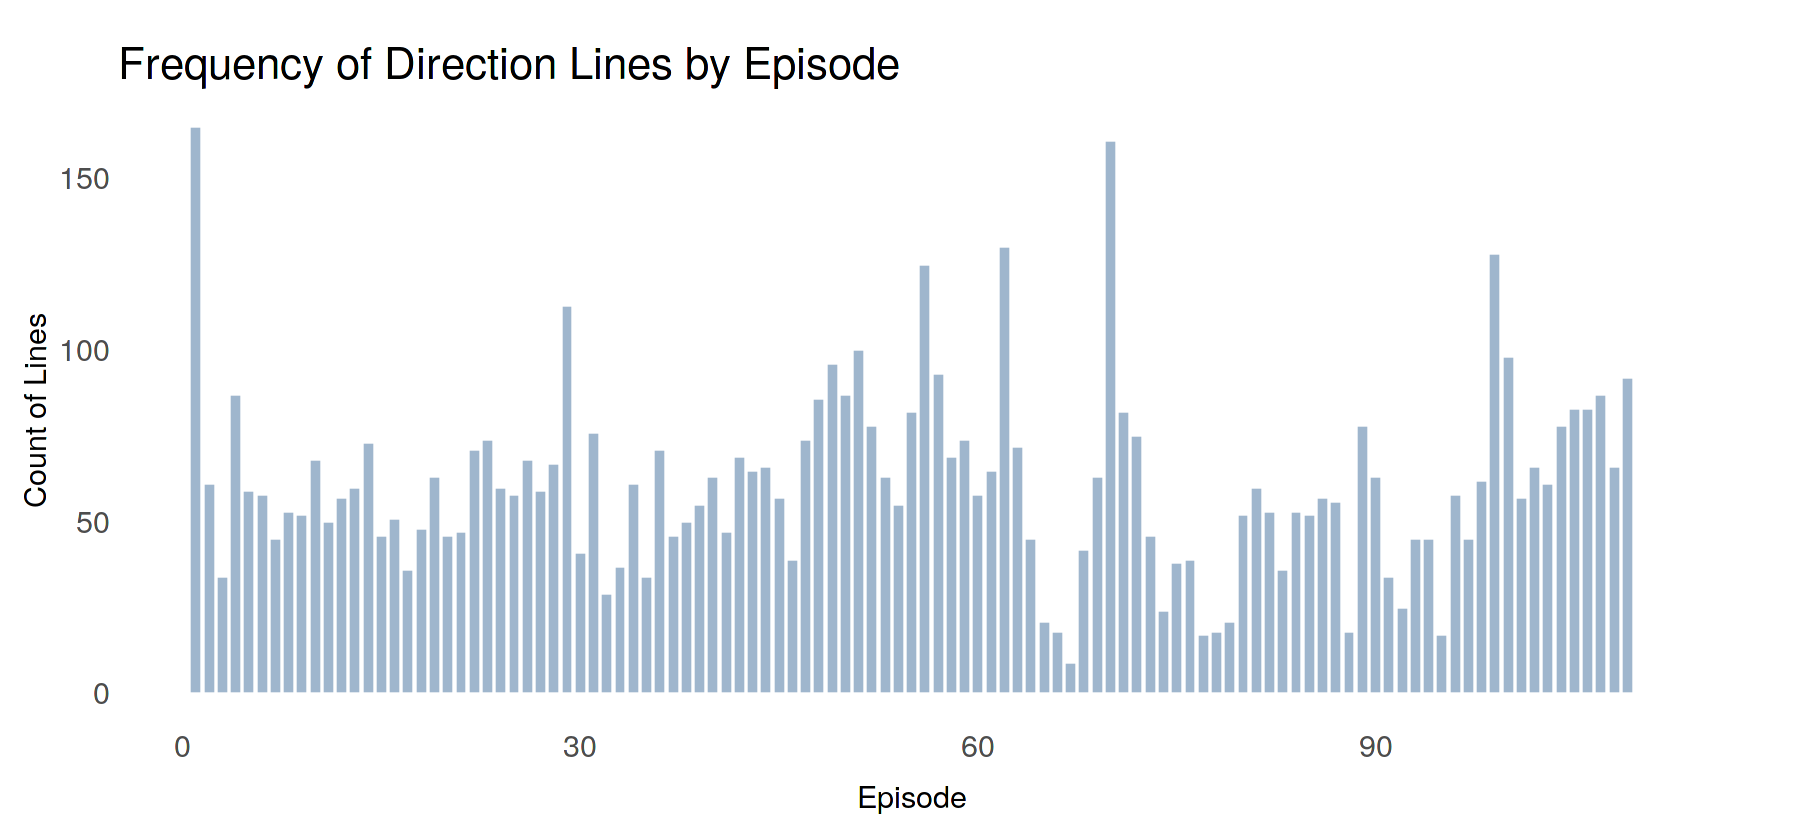

In [17]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(subset(sg1corpus, character == "directions"),
       aes(x = episode_index)) +
  geom_bar(fill = "slategray3", colour = "white") +
  theme_tb() +
  labs(y = "Count of Lines", 
       x = "Episode",
       title = "Frequency of Direction Lines by Episode")

I note that episode 67 and 70 there is a large drop/spike in stage direction frequency respectively. I believe these scripts had outlying writing styles, one of which included a lot more detail in the direction content, and the other the opposite. It is worth investigating and I will review the content to be sure.

In [18]:
S04E02 <-
  subset(sg1corpus, character == "directions" &
           episode_index == 67) %>%
  select(season_number, episode_number, episode_index, content)
S04E05 <-
  subset(sg1corpus, character == "directions" &
           episode_index == 70) %>%
  select(season_number, episode_number, episode_index, content)
head(S04E02)
head(S04E05)

season_number,episode_number,episode_index,content
<dbl>,<dbl>,<dbl>,<chr>
4,2,67,man continues asking for other man i cant understand no closed captioning im doing it from an asf he said something about going through the portal
4,2,67,opening credits
4,2,67,they step through the gate and feel the ground shaking they hear alar moaning and sam runs to him
4,2,67,jack walks yup to them an explosion happens and nearly knocks him down
4,2,67,the ground glasses and chandelier starts shaking
4,2,67,jack leaves follows by tealc sam stands at the door for danny to proceed her then leaves at the base


season_number,episode_number,episode_index,content
<dbl>,<dbl>,<dbl>,<chr>
4,5,70,vorash the tokra headquarters planet exterior shot a stargate in a desolate landscape sandy with oddly shaped obelisk like rocks interior tokra tunnels tokra council chamber oneill jackson martouf anise freya major graham and captain blasdale are sitting around the table
4,5,70,martouf stands when he hears persuss voice two guards and high councilor persus enter the chamber everyone else stands and martouf walks toward persus
4,5,70,as martouf introduces the tauri to the high councilor we see graham with a tiny goauld energy weapon disguised as a ring in the palm of his hand he pushes something and it opens up he turns his hand so no one else can see it then back to martouf bowing to persus
4,5,70,daniel walks forward and bows to persus
4,5,70,behind daniel major graham aims the goauld weapon at persus
4,5,70,oneill ducks graham shoots a blast from the ring weapon it goes straight through a tokra bodyguard and hits persus in the chest knocking him down captain blasdale tries to get the weapon from graham and graham blows a hole through the captain the second tokra bodyguard tries to hit graham with a zat gun and gets shot as well then graham turns toward freya who is hiding behind the table oneill sees this jumps over the table and knocks freya to the floor the blast barely misses them daniel crouching against a wall looks flabbergasted grahams eyes are wide as he points the weapon at oneill


From this review we can see S04E02 has much briefer directions compared to S04E05 but both are genuine and are likely due to variances in the type of content in each episode and/or writing style.

<a id="subsection-two"></a>
## Total Character Dialogue Lines Frequency Review
This visualisation quickly acts as a sense check to ensure that the logic is not missing lines to a significant degree, we should not note any huge deviation in line volume for an episode. The only exception we note is episode 1 where the script combines part 1 and part 2 of this episode (Children of the Gods). This will also be important to keep in mind for upcoming analysis on this dataset.

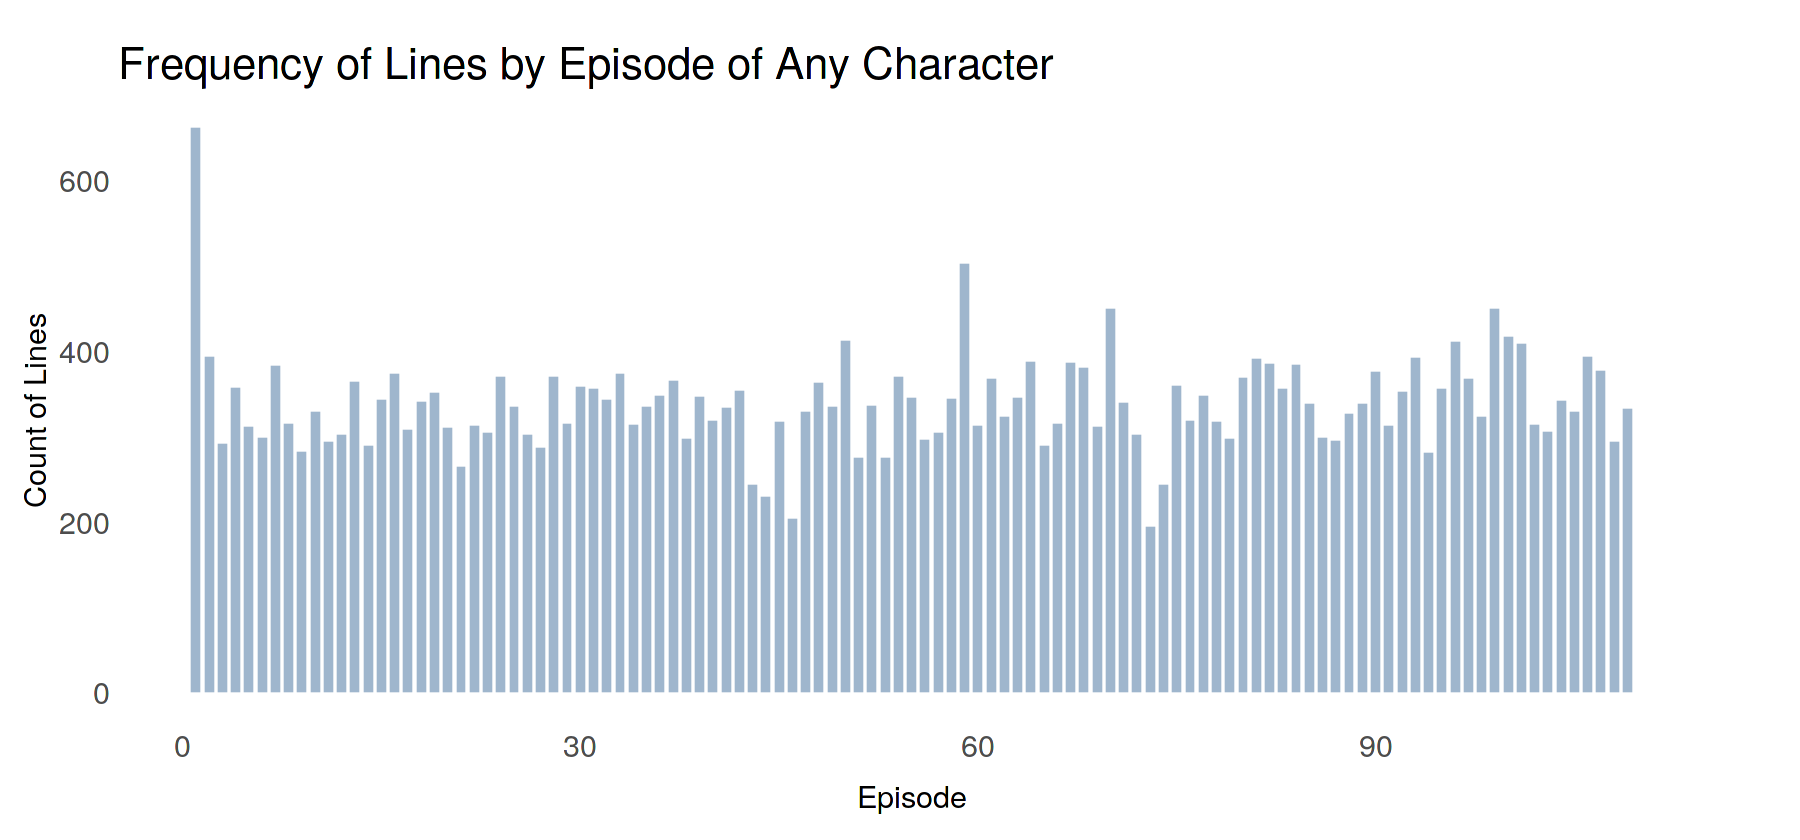

In [19]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(subset(sg1corpus, character != "directions"),
       aes(x = episode_index)) +
  geom_bar(fill = "slategray3", colour = "white") +
  theme_tb() +
  labs(y = "Count of Lines", 
       x = "Episode",
       title = "Frequency of Lines by Episode of Any Character")

<a id="subsection-three"></a>
## Main Character Line Frequency Review

During my review of the raw scripts I noted that ocassionally the writer would refer to Jack as O'Neill and Sam as Carter which was the exception. This was straightforward to quickly account for in the code but this quick visualisation acts as a sense checker and reveals if any episodes have no lines by any of the four main characters. In reality this is very unlikely except for some known cases, so we can easily pick up on any major changes in naming conventions which likely affected other minor characters.

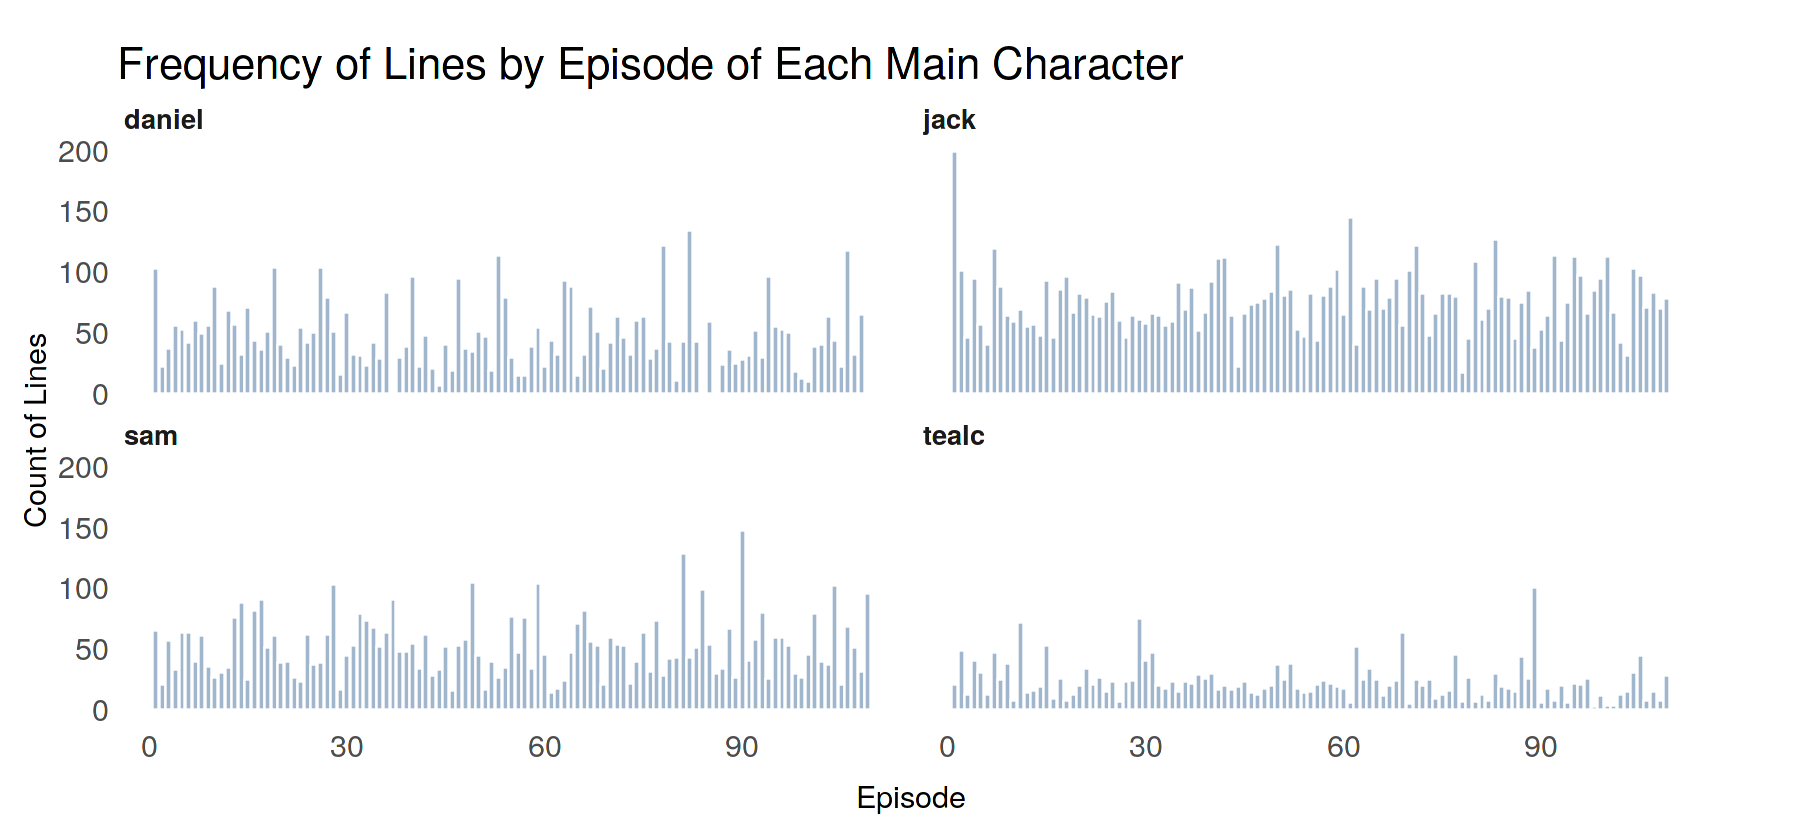

In [20]:
options(repr.plot.width = 15, repr.plot.height = 7)
maincharlines <-
  subset(
    sg1corpus,
    character == "sam" |
      character == "jack" |
      character == "daniel" |
      character == "tealc"
  )
ggplot(maincharlines, aes(x = episode_index)) +
  geom_bar(fill = "slategray3", colour = "white") +
  theme_tb() +
  facet_wrap( ~ character) +
  labs(y = "Count of Lines",
       x = "Episode",
       title = "Frequency of Lines by Episode of Each Main Character")

I return a table of all episodes where a character has no lines at all which are interestingly all Daniel. Upon a manual review of the original scripts they are genuine as I note below with the other outliers.

In [21]:
subset(maincharlines) %>%
  group_by(episode_index,
           season_number,
           episode_number,
           episode_name,
           character) %>%
  tally(sort = FALSE) %>%
  pivot_wider(names_from = character, values_from = n) %>%
  subset(is.na(tealc) | is.na(jack) | is.na(sam) | is.na(daniel))

episode_index,season_number,episode_number,episode_name,daniel,jack,sam,tealc
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>
84,4,19,prodigy,NA,80,99,19
86,4,21,double jeopardy,NA,45,30,15
109,5,22,revelations,NA,78,96,28


- Season 2 Episode 16 "A Matter of Time" Daniel has two lines where at the end of the episode. He was with SG6 on a dig at P3X-808 for the majority of this time.
- Season 3 Episode 1 "Into the Fire" has a very low frequency of lines for Jack which is unusual. This is the episode where he is taken by a Goa'uld and is MIA for a period of time. 
- Season 4 Episode 13 "The Curse" has a low frequency for Jack again, this is because he is fishing in Minnesota with Teal'c who also has a low number of lines for this episode relative to others, although not to the same extent.
- Season 4 episode 19 "Prodigy" where Dr. Jackson is offworld with SG11.
- Season 4 episode 21 "Double Jeapordy" is where most characters are replaced by clones and the real Daniel appears to have no lines at all.
- Season 5 episode 22 "Revelations" is the episode where Daniel ascends so naturally he has no lines.

<a id="subsection-four"></a>
## Frequency of Main Character Mentions in Dialogue
This visualisation tracks how many times a main character is mentioned in dialogue by any other character. To look at this it was important to: 
1. Replace any instances of O'Neill with Jack, and Carter with Sam so we knew when the character was being mentioned regardless of the alias used. 
2. I also replaced the bi-gram "Jack O'Neill" with just "Jack" prior to this so I didn't double up in these cases.
3. Occasionally Teal'c would combine a characters rank and surname or given and surnames into one word so this was accounted for as well.
3. I then removed any text surrounded by brackets () as I found that this text represented embedded commentary/directions in lines of dialogue in certain transcribing styles.

In [22]:
sg1corpusdialoguewords <-
  subset(sg1corpus, character != "directions") %>%
  mutate(content = str_replace_all(content, "jack oneill", "jack")) %>%
  mutate(content = str_replace_all(content, "danieljackson", "daniel")) %>%
  mutate(content = str_replace_all(content, "captaincarter", "sam")) %>%
  mutate(content = str_replace_all(content, "majorcarter", "sam")) %>%
  mutate(content = str_replace_all(content, "oneill", "jack")) %>%
  mutate(content = str_replace_all(content, "carter", "sam")) %>%
  mutate(content = str_replace_all(content, "danny", "daniel")) %>%
  mutate(content = str_replace_all(content, "jacks", "jack")) %>%
  mutate(content = str_replace_all(content, "sams", "sam")) %>%
  mutate(content = str_replace_all(content, "daniels", "daniel")) %>%
  mutate(content = str_replace_all(content, "tealcs", "tealc")) %>%
  mutate(content = removeWords(content, stopwords("en"))) %>%
  mutate(content = stripWhitespace(trim(content))) %>%
  subset(content != "") %>%
  separate_rows(content, sep = " ") %>%
  group_by(episode_index,
           season_number,
           episode_number,
           episode_name,
           content) %>%
  tally(sort = FALSE)

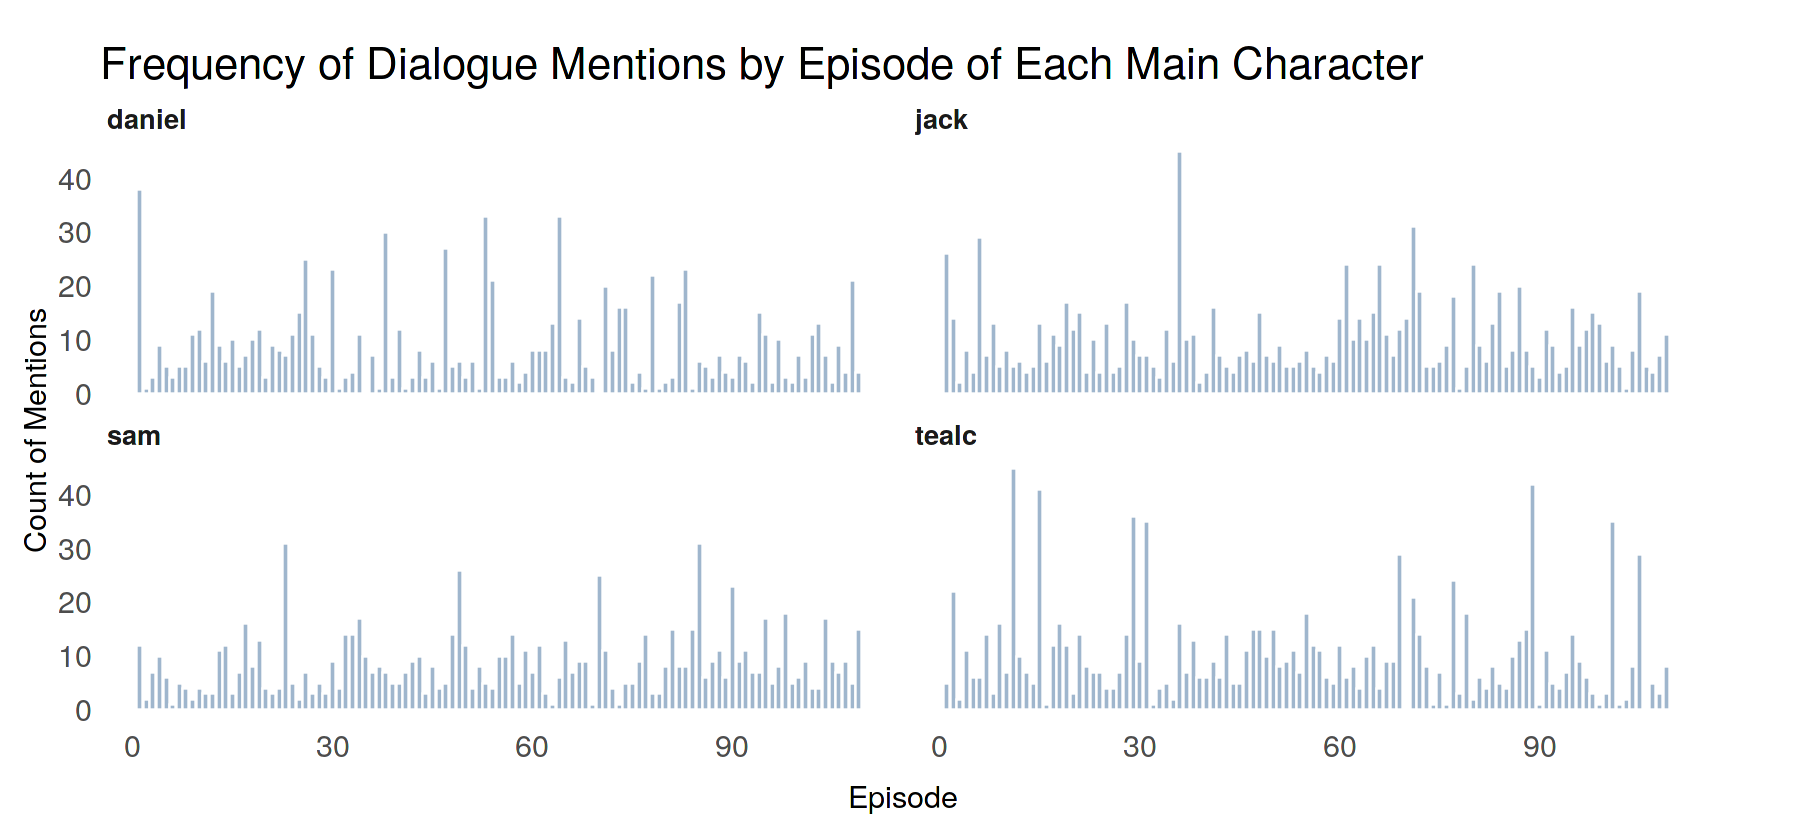

In [23]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(subset(
  sg1corpusdialoguewords,
  content %in% c("sam", "jack", "daniel", "tealc")
),
aes(x = episode_index, y = n)) +
  geom_bar(stat = "identity",
           fill = "slategray3",
           colour = "white") +
  theme_tb() +
  facet_wrap( ~ content) +
  labs(y = "Count of Mentions",
       x = "Episode",
       title = "Frequency of Dialogue Mentions by Episode of Each Main Character")

I return a table of all episodes where a character is not mentioned at all in dialogue. Upon a manual review of the original scripts these all appear genuine.

In [24]:
subset(sg1corpusdialoguewords,
    content %in% c("sam", "jack", "daniel", "tealc")) %>% 
pivot_wider(names_from = content, values_from = n) %>%
subset(is.na(tealc) | is.na(jack) | is.na(sam) | is.na(daniel))

episode_index,season_number,episode_number,episode_name,daniel,jack,sam,tealc
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>
35,2,14,touchstone,NA,6,10,2
70,4,5,divide and conquer,NA,14,25,NA
106,5,19,menace,9,5,7,NA


<a id="section-fourteen"></a>
# Preview the Stargate SG1 Corpus

In [25]:
sg1corpus <-
  select(sg1corpus,-text_type) #Also remove the now redundant text_type field prior to writing
head(sg1corpus)
tail(sg1corpus)

index,season_number,episode_index,episode_number,episode_name,episode_writer,character,content
<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,1,1,children of the gods,jonathan glassner and brad wright,directions,the opening scene starts in the gateroom the gate is covered and in a corner of the room a group of four military personnel are playing a game of cards
2,1,1,1,children of the gods,jonathan glassner and brad wright,airman,oh man this hands as lousy as this detail all right everybody in or out
3,1,1,1,children of the gods,jonathan glassner and brad wright,directions,one of the personnel deals out some cards
4,1,1,1,children of the gods,jonathan glassner and brad wright,airman,seven to the deuce nothing there boss on the eight nothing happening queen to the king possible straight going there eight on the eight and the jack gets a box eights open
5,1,1,1,children of the gods,jonathan glassner and brad wright,female,arent you guys afraid of an officer coming down here or something
6,1,1,1,children of the gods,jonathan glassner and brad wright,officer,trust me nobody ever comes down here but us


index,season_number,episode_index,episode_number,episode_name,episode_writer,character,content
<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
43814,5,109,22,revelations,joseph mallozzi and paul mullie,directions,suddenly sams hair is ruffled by a gust of wind
43815,5,109,22,revelations,joseph mallozzi and paul mullie,sam,what was that
43816,5,109,22,revelations,joseph mallozzi and paul mullie,tealc,perhaps a malfunction in the ventilation system
43817,5,109,22,revelations,joseph mallozzi and paul mullie,jack,yeah thats probably it
43818,5,109,22,revelations,joseph mallozzi and paul mullie,sam,bye sir have a good night
43819,5,109,22,revelations,joseph mallozzi and paul mullie,directions,hammond walks off past martin wood and sergeant siler sam walks into the elevator and tealc follows another gust of wind ruffles jacks hair and he turns into the elevator smiling
